# Pulse gates

Most quantum algorithms can be described with circuit operations alone. When we need more control over the low-level implementation of our program, we can use _pulse gates_. Pulse gates remove the constraint of executing circuits with basis gates only, and also allow you to override the default implementation of any basis gate.

Pulse gates allow you to map a logical circuit gate (e.g., `X`) to a Qiskit Pulse program, called a `Schedule`. This mapping is referred to as a _calibration_. A high fidelity calibration is one which faithfully implements the logical operation it is mapped from (e.g., whether the `X` gate calibration drives $|0\rangle$ to $|1\rangle$, etc.).

A schedule specifies the exact time dynamics of the input signals across all input _channels_ to the device. There are usually multiple channels per qubit, such as drive and measure. This interface is more powerful, and requires a deeper understanding of the underlying device physics.

It's important to note that Pulse programs operate on physical qubits. A drive pulse on qubit $a$ will not enact the same logical operation on the state of qubit $b$ -- in other words, gate calibrations are not interchangeable across qubits. This is in contrast to the circuit level, where an `X` gate is defined independent of its qubit operand.

This page shows you how to add a calibration to your circuit.

**Note:** To execute a program with pulse gates, the backend has to be enabled with OpenPulse. You can check via ``backend.configuration().open_pulse``, which is ``True`` when OpenPulse is enabled. If it is enabled and the pulse gates feature is not enabled, you can [schedule](07_pulse_scheduler.ipynb) your input circuit.

## Build your circuit

Let's start with a very simple example, a Bell state circuit.

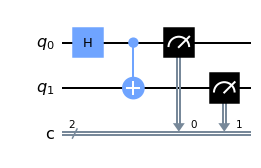

In [1]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)

circ.draw('mpl')

## Build your calibrations

Now that we have our circuit, let's define a calibration for the Hadamard gate on qubit 0.

In practice, the pulse shape and its parameters would be optimized through a series of Rabi experiments (see the [Qiskit Textbook](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-openpulse.html) for a walk through). For this demonstration, our Hadamard will be a Gaussian pulse. We will _play_ our pulse on the _drive_ channel of qubit 0.

Don't worry too much about the details of building the calibration itself; you can learn all about this on the following page: [building pulse schedules](06_building_pulse_schedules.ipynb).

In [2]:
from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit.test.mock import FakeValencia

backend = FakeValencia()

with pulse.build(backend, name='hadamard') as h_q0:
    pulse.play(Gaussian(duration=128, amp=0.1, sigma=16), pulse.drive_channel(0))

Let's draw the new schedule to see what we've built.

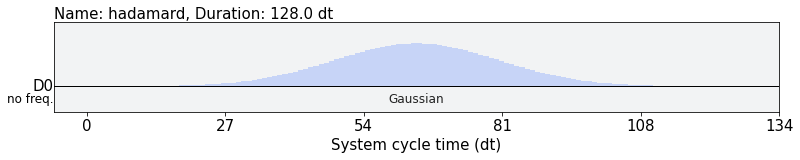

In [3]:
h_q0.draw()

## Link your calibration to your circuit

All that remains is to complete the registration. The circuit method `add_calibration` needs information about the gate and a reference to the schedule to complete the mapping:

    QuantumCircuit.add_calibration(gate, qubits, schedule, parameters)

The `gate` can either be a `circuit.Gate` object or the name of the gate. Usually, you'll need a different schedule for each unique set of `qubits` and `parameters`. Since the Hadamard gate doesn't have any parameters, we don't have to supply any.

In [4]:
circ.add_calibration('h', [0], h_q0)

Lastly, note that the transpiler will respect your calibrations. Use it as you normally would (our example is too simple for the transpiler to optimize, so the output is the same).

['id', 'u1', 'u2', 'u3', 'cx']


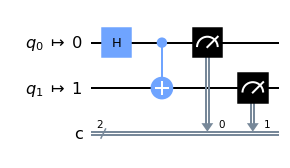

In [5]:
from qiskit import transpile
from qiskit.test.mock import FakeAlmaden

backend = FakeAlmaden()

circ = transpile(circ, backend)

print(backend.configuration().basis_gates)
circ.draw('mpl', idle_wires=False)

Notice that `h` is not a basis gate for the mock backend `FakeAlmaden`. Since we have added a calibration for it, the transpiler will treat our gate as a basis gate; _but only on the qubits for which it was defined_. A Hadamard applied to a different qubit would be unrolled to the basis gates.

That's it!

## Custom gates

We'll briefly show the same process for nonstandard, completely custom gates. This demonstration includes a gate with parameters.

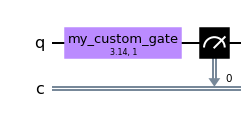

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

circ = QuantumCircuit(1, 1)
custom_gate = Gate('my_custom_gate', 1, [3.14, 1])
# 3.14 is an arbitrary parameter for demonstration
circ.append(custom_gate, [0])
circ.measure(0, 0)

circ.draw('mpl')

In [7]:
with pulse.build(backend, name='custom') as my_schedule:
    pulse.play(Gaussian(duration=64, amp=0.2, sigma=8), pulse.drive_channel(0))

circ.add_calibration('my_custom_gate', [0], my_schedule, [3.14, 1])
# Alternatively: circ.add_calibration(custom_gate, [0], my_schedule)

If we use the `Gate` instance variable `custom_gate` to add the calibration, the parameters are derived from that instance. Remember that the order of parameters is meaningful.

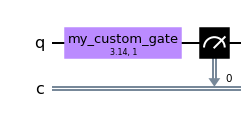

In [8]:
circ = transpile(circ, backend)
circ.draw('mpl', idle_wires=False)

Normally, if we tried to transpile our `circ`, we would get an error. There was no functional definition provided for `"my_custom_gate"`, so the transpiler can't unroll it to the basis gate set of the target device. We can show this by trying to add `"my_custom_gate"` to another qubit which hasn't been calibrated.

In [9]:
circ = QuantumCircuit(2, 2)
circ.append(custom_gate, [1])


from qiskit import QiskitError
try:
    circ = transpile(circ, backend)
except QiskitError as e:
    print(e)

"Cannot unroll the circuit to the given basis, ['id', 'u1', 'u2', 'u3', 'cx']. Instruction my_custom_gate not found in equivalence library and no rule found to expand."


In [10]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright